In [1]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import dataframe_image as dfi

import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import matplotlib.cm 
import matplotlib.colors 
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, fasta_file_parser_gtdb, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.gene import Gene, Genome
from selenobot.organism import Organism

%load_ext autoreload 
%autoreload 2


In [2]:
species = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 

# Using the genomes from the GTDB species representative for release r207.
genome_ids = dict() 
genome_ids['Pseudomonas aeruginosa'] = 'GCF_001457615.1'
genome_ids['Bacillus subtilis'] = 'GCF_000009045.1'
genome_ids['Escherichia coli'] = 'GCF_000195955.2'
genome_ids['Mycobacterium tuberculosis'] = 'GCF_003697165.2'
genome_ids['Aliivibrio fischeri'] = 'GCF_016464335.1'

genome_metadata_df = pd.read_csv('../data/gtdb_genome_metadata_bacteria.csv', index_col=0)
genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(species)]
genome_metadata_df[['species', 'genome_size', 'gc_percentage']]

,species,genome_size,gc_percentage
genome_id,,,
GCF_001457615.1,Pseudomonas aeruginosa,6316979,66.522953
GCF_000009045.1,Bacillus subtilis,4215606,43.514408
GCF_000195955.2,Mycobacterium tuberculosis,4411532,65.614666
GCF_003697165.2,Escherichia coli,5034834,50.644450
GCF_016464335.1,Aliivibrio fischeri,4300704,38.245020


In [3]:
if (not os.path.exists('../data/model_organisms/organisms.pkl')):
    organisms = list()
    for species in genome_ids.keys():
        print(f'\n{species}')
        organism = Organism(genome_ids[species], species)
        organism.label()
        organisms.append(organism)
    with open('../data/model_organisms/organisms.pkl', 'wb') as f:
        pickle.dump(organisms, f)
else:
    with open('../data/model_organisms/organisms.pkl', 'rb') as f:
        organisms = pickle.load(f)


def make_summary_table(path='../data/model_organisms/summary_table.png'):   
    table_df = list()
    for organism in organisms:
        row = dict()
        row['species'] = organism.species
        row['GC content'] = organism.species
        row['ref. genome size'] = organism.size(source='ncbi', pseudo=False)
        row['GTDB genome size'] = organism.size(source='gtdb')
        row['num. pseudogenes'] = organism.size(source='ncbi', pseudo=True)
        row['perc. exact matches'] = f'{100 * len(organism.to_df(label='match')) / organism.size(source='gtdb'):.2f}%'
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('species')
    dfi.export(table_df, path)

make_summary_table()


Pseudomonas aeruginosa


search: 100%|██████████| 5788/5788 [01:10<00:00, 81.78it/s]


Organism.label: Found 30 sequences in the input genome with the "inter" label.
Organism.label: Found 303 sequences in the input genome with the "error" label.
Organism.label: Found 154 sequences in the input genome with the "pseudo" label.
Organism.label: Found 5761 sequences in the input genome with the "cds" label.
Organism.label: Found 0 sequences in the input genome with the "rna" label.
Organism.label: Found 2 sequences in the input genome with the "misc" label.

Bacillus subtilis


search: 100%|██████████| 4226/4226 [00:44<00:00, 95.27it/s] 


Organism.label: Found 34 sequences in the input genome with the "inter" label.
Organism.label: Found 233 sequences in the input genome with the "error" label.
Organism.label: Found 35 sequences in the input genome with the "pseudo" label.
Organism.label: Found 4148 sequences in the input genome with the "cds" label.
Organism.label: Found 15 sequences in the input genome with the "rna" label.
Organism.label: Found 35 sequences in the input genome with the "misc" label.

Escherichia coli


search: 100%|██████████| 4717/4717 [01:02<00:00, 75.80it/s] 


Organism.label: Found 52 sequences in the input genome with the "inter" label.
Organism.label: Found 250 sequences in the input genome with the "error" label.
Organism.label: Found 152 sequences in the input genome with the "pseudo" label.
Organism.label: Found 4668 sequences in the input genome with the "cds" label.
Organism.label: Found 8 sequences in the input genome with the "rna" label.
Organism.label: Found 2 sequences in the input genome with the "misc" label.

Mycobacterium tuberculosis


search: 100%|██████████| 4085/4085 [00:43<00:00, 93.30it/s] 


Organism.label: Found 149 sequences in the input genome with the "inter" label.
Organism.label: Found 593 sequences in the input genome with the "error" label.
Organism.label: Found 9 sequences in the input genome with the "pseudo" label.
Organism.label: Found 3900 sequences in the input genome with the "cds" label.
Organism.label: Found 5 sequences in the input genome with the "rna" label.
Organism.label: Found 71 sequences in the input genome with the "misc" label.

Aliivibrio fischeri


search: 100%|██████████| 3853/3853 [00:26<00:00, 147.74it/s]


Organism.label: Found 56 sequences in the input genome with the "inter" label.
Organism.label: Found 168 sequences in the input genome with the "error" label.
Organism.label: Found 57 sequences in the input genome with the "pseudo" label.
Organism.label: Found 3800 sequences in the input genome with the "cds" label.
Organism.label: Found 4 sequences in the input genome with the "rna" label.
Organism.label: Found 0 sequences in the input genome with the "misc" label.


In [4]:
usecols = ['binary_model_plm_pt5_prediction', 'binary_model_plm_esm_prediction'] 
pred_df = list()
for organism in organisms:
    df = pd.read_csv(f'../data/results/gtdb_{organism.code_name}.predict.csv', index_col=0)[usecols]
    df = df.merge(organism.to_df(), left_index=True, right_index=True, how='left')
    pred_df.append(df)
pred_df = pd.concat(pred_df)
pred_sec_df = pred_df[pred_df.binary_model_plm_pt5_prediction == 1]

# for species, species_df in pred_df.groupby('species'):
#     print('\nSpecies:', species)
#     print('Predicted positive cases by ESM-based model:', (species_df.binary_model_plm_esm_prediction == 1).sum())
#     print('Predicted positive cases by ProtT5-based model:', (species_df.binary_model_plm_pt5_prediction == 1).sum())

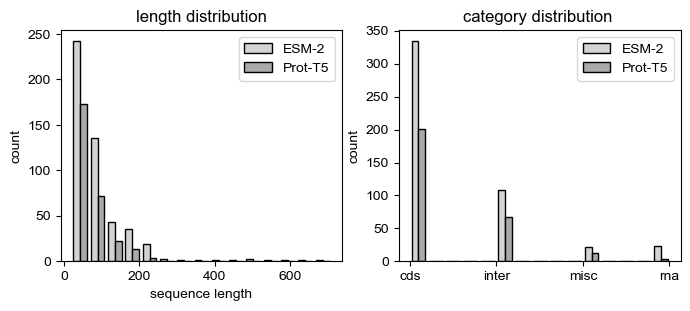

In [5]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=2)

ax = axes[0]
hist = []
for model_type in ['plm_esm', 'plm_pt5']:
    lengths = pred_df[pred_df[f'binary_model_{model_type}_prediction'] == 1].seq.apply(len)
    hist.append(lengths)
    
ax.hist(hist, bins=15, color=['lightgray', 'darkgray'], edgecolor='black', lw=0.5)
ax.legend(['ESM-2', 'Prot-T5'])
ax.set_ylabel('count')
ax.set_xlabel('sequence length')
ax.set_title('length distribution')

ax = axes[1]
hist = []
for model_type in ['plm_esm', 'plm_pt5']:
    labels = pred_df[pred_df[f'binary_model_{model_type}_prediction'] == 1].label.fillna('none').values
    hist.append(labels)

ax.hist(tuple(hist), bins=15, color=['lightgray', 'darkgray'], edgecolor='black', lw=0.5)
ax.legend(['ESM-2', 'Prot-T5'])
ax.set_ylabel('count')
ax.set_title('category distribution ')
plt.show()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

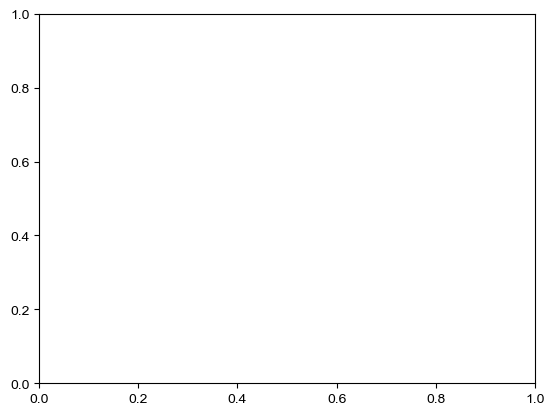

In [6]:
# Want to capture the differences between GTDB and the NCBI reference in label composition, as well as length. 
# On the x-axis, three categories: genes in both genomes, genes in just GTDB, genes in just NCBI. 
fig, ax = plt.subplots()

def organisms_to_df(labels:list):
    df = list()
    for label in labels:
        df.append(pd.concat([organism.to_df(label=label) for organism in organisms]))
    return pd.concat(df)

gtdb_genes = organisms_to_df(labels=['none', 'inter'])
shared_genes = organisms_to_df(labels['misc', 'rna', 'pseudo', 'error', 'match'])



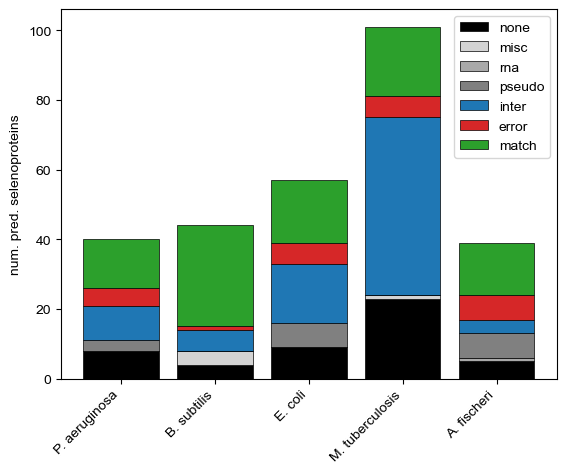

In [ ]:
fig, ax = plt.subplots()

color_map = {'match':'tab:green', 'error':'tab:red', 'inter':'tab:blue', 'pseudo':'gray', 'rna':'darkgray', 'none':'black', 'misc':'lightgray'}
labels = ['none', 'misc', 'rna', 'pseudo', 'inter', 'error', 'match']
species = list(genome_ids.keys()) 

bottom = np.zeros(len(species))
for label in labels:
    label_df = pred_df[(pred_df.label == label) & (pred_df.binary_model_plm_pt5_prediction == 1)]
    # label_df = pd.concat([organism.to_df(label=label) for organism in organisms])
    heights = np.array([(label_df.species == s).sum() for s in species])
    ax.bar(np.arange(len(organisms)), heights, bottom=bottom, color=color_map[label], edgecolor='black', linewidth=0.5)
    bottom += heights

ax.set_xticks(np.arange(len(organisms)), labels=[f'{organism.species.split()[0][0]}. {organism.species.split()[-1]}' for organism in organisms], rotation=45, ha='right')
ax.legend(labels)
# ax.set_yscale('log')
ax.set_ylabel('num. pred. selenoproteins')
plt.show()



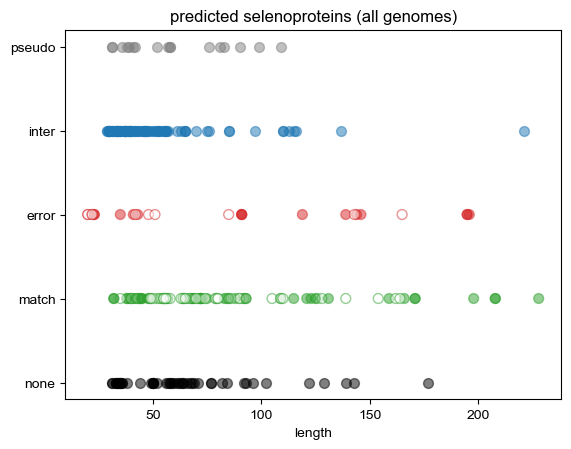

In [42]:
fig, ax = plt.subplots()

info_dfs = dict()
info_dfs['match'] = pd.concat([organism.get_match_info() for organism in organisms]) 
info_dfs['error'] = pd.concat([organism.get_error_info() for organism in organisms]) 

labels = ['none', 'match', 'error', 'inter', 'pseudo']
for i, label in enumerate(labels):
    df = pd.concat([organism.to_df(label=label) for organism in organisms]) 
    df = df[df.index.isin(pred_sec_df.index)]

    color = color_map[label]
    if label in info_dfs:
        info_df = info_dfs[label]
        info_df = info_df[info_df.index.isin(df.index)]
        color = [color_map[label] if ('hypothetical' not in prod) else 'white' for prod in info_df['product']]

    ax.scatter(df.seq.apply(len), [i] * len(df), edgecolor=color_map[label], linewidths=1, color=color, alpha=0.5, s=50)

# ax.set_xlim(0, 300)
ax.set_yticks(np.arange(len(labels)), labels=labels)
ax.set_xlabel('length')
ax.set_title('predicted selenoproteins (all genomes)')

plt.show()



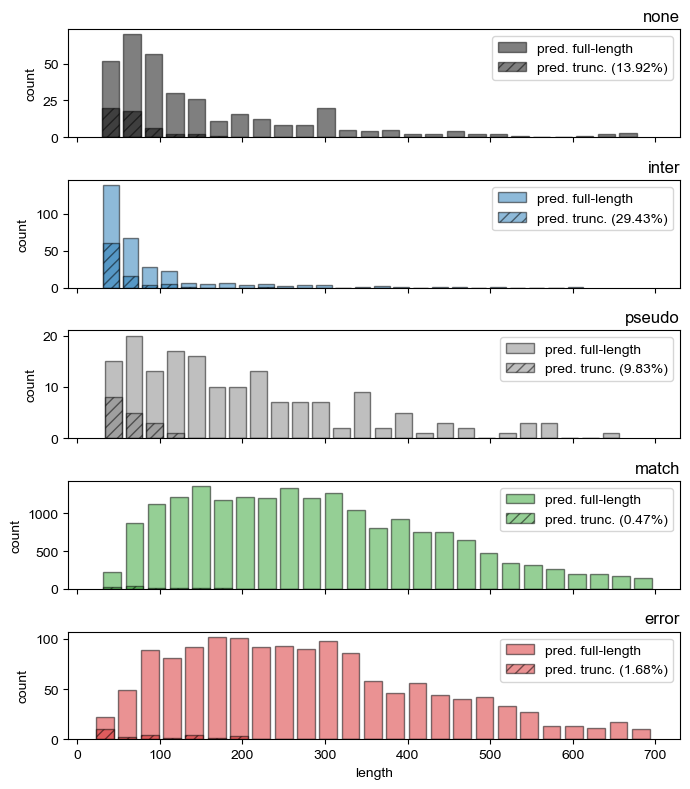

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(7, 8), sharex=True)

max_length = 700
labels = ['none', 'inter', 'pseudo', 'match', 'error']
for ax, label in zip(axes, labels):
    df = pd.concat([organism.to_df(label=label) for organism in organisms]) 
    lengths = df.seq.apply(len)
    _, bin_edges, _, = ax.hist(lengths[lengths < max_length], color=color_map[label], bins=25, rwidth=0.8, edgecolor='black', alpha=0.5)
    p = f'{100 * df.index.isin(pred_sec_df.index).sum() / len(df):.2f}%'

    df = df[df.index.isin(pred_sec_df.index)] # Filter for predicted selenoproteins. 
    lengths = df.seq.apply(len)
    ax.hist(lengths[lengths < max_length], color=color_map[label], bins=bin_edges, rwidth=0.8, edgecolor='black', alpha=0.5, hatch='///')

    ax.set_ylabel('count')
    ax.set_title(label, loc='right')
    ax.legend(['pred. full-length', f'pred. trunc. ({p})'])

ax.set_xlabel('length')
plt.tight_layout()
plt.show()

In [10]:
def load_embeddings(label:str, feature_type:str='plm_esm'):
    '''Load in the PLM embeddings which correspond to sequences with a specific label.'''
    ids = np.concatenate([organism.to_df(label=label).index for organism in organisms])

    emb_df = []
    seqs = []
    for organism in organisms:
        df = pd.read_hdf(f'../data/model_organisms/gtdb_{organism.code_name}.h5', key=feature_type)
        seq_df = pd.read_hdf(f'../data/model_organisms/gtdb_{organism.code_name}.h5', key='metadata')[['seq']]
        
        mask = df.index.isin(ids) 
        emb_df.append(df[mask])
        seqs += list(seq_df[mask].values.ravel())
    emb_df = pd.concat(emb_df)

    return emb_df, seqs


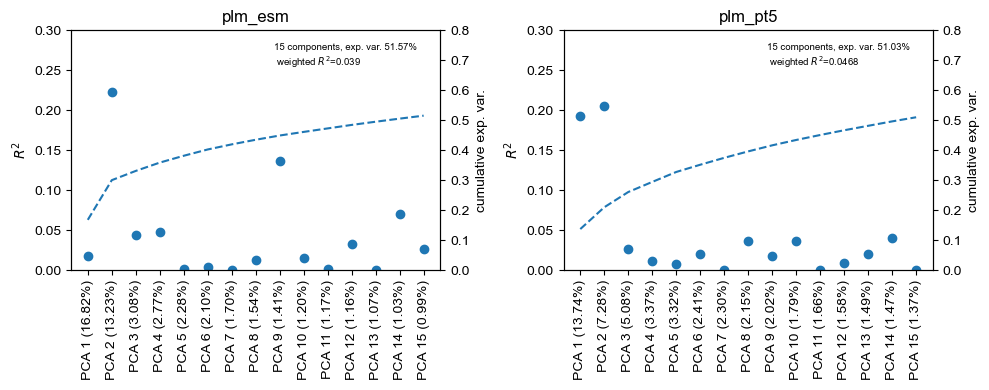

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

label = 'inter'
n_comps = 15 
plot_n_comps = 15

# for ax, feature_type in zip(axes, ['plm_esm', 'plm_pt5']):
for ax, feature_type in zip(axes, ['plm_esm', 'plm_pt5']):

    emb_df, seqs = load_embeddings(label, feature_type=feature_type)
    lengths = np.array([len(seq) for seq in seqs])

    emb, index = emb_df.values, emb_df.index

    scaler = StandardScaler()
    emb = scaler.fit_transform(emb)
    pca = PCA(n_components=n_comps)
    comps = pca.fit_transform(emb)

    exp_vars = pca.explained_variance_ratio_
    # print(f'Total explained variance: {100 * exp_var.sum():.2f}%')

    x_labels = []
    x = list(range(plot_n_comps))
    y1, y2 = list(), list()

    for i in range(n_comps):
        comp = comps[:, i].ravel()

        linreg = LinearRegression()
        linreg.fit(lengths.reshape(-1, 1), comp)
        r2 = linreg.score(lengths.reshape(-1, 1), comp)
        x_labels.append(f'PCA {i + 1} ({100 * exp_vars[i]:.2f}%)')
        y1.append(r2)
        y2.append(exp_vars[:i + 1].sum())

    ax.scatter(x, y1[:plot_n_comps], c=color_map[label])
    ax.set_ylim(0, 0.3)
    ax.set_ylabel('$R^2$')
    right_ax = ax.twinx()
    right_ax.plot(x, y2[:plot_n_comps], c=color_map[label], linestyle='--')
    right_ax.set_ylim(0, 0.8)
    right_ax.set_ylabel('cumulative exp. var.')

    ax.set_xticks(x, labels=x_labels[:plot_n_comps], rotation=90)
    ax.set_title(feature_type)

    weighted_r2 = (np.array(y1) * exp_vars).sum()
    ax.text(0.55, 0.85, f'{n_comps} components, exp. var. {exp_vars.sum() * 100:.2f}%\n weighted $R^2$={np.round(weighted_r2, 4)}', fontsize='x-small', transform=ax.transAxes)


# ax.set_xlabel(f'PCA 1 ({100 * exp_var[0]:.2f}%)')
# ax.set_ylabel(f'PCA 2 ({100 * exp_var[1]:.2f}%)')

# colors = [color_map[label] if id_ in pred_df.index else 'white' for id_ in index]
# sizes = [len(seq) / 10 for seq in seqs]
# ax.scatter(comps[:, 0], comps[:, 1], edgecolors=color_map[label], linewidth=0.7, color=colors, sizes=sizes)
plt.tight_layout()
plt.show()

